# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

# TASK 1

In [2]:
import torch
from model import LeNet5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

model = LeNet5()
model.load_state_dict(torch.load('LeNet5_weights.pkl', weights_only=True))
model = model.to(device)
model.eval()

Working on cuda


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.05, inplace=False)
  (dense1): Linear(in_features=120, out_features=84, bias=True)
  (dense2): Linear(in_features=84, out_features=10, bias=True)
)

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt



transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


def get_batch_n_samples(dataset, n_per_class=9):
    selected_idx = []

    for num_class in range(1,10):
        indexes = [i for i, (_, label) in enumerate(dataset) if label == num_class]
        selected = indexes[0:n_per_class]   # <- for example 9 x "ones"
        selected_idx.extend(selected)

    images = torch.stack([dataset[i][0] for i in selected_idx])
    labels = torch.tensor([dataset[i][1] for i in selected_idx])

    return images, labels 


train_images, train_targets = get_batch_n_samples(trainset, n_per_class=9)#(90,1,2,28), (90,)

In [4]:
def dreamingLeNet5(lambda_l2=0):
    imgs = torch.randn(10, 1, 28, 28, requires_grad=True)
    imgs = imgs.to(device).clone().detach().requires_grad_()
    targets = torch.arange(10).to(device)

    model.eval()
    optimizer = torch.optim.Adam([imgs], lr=0.05)


    for step in range(1000):
        optimizer.zero_grad()

        batch_outputs = (model(imgs)).to(device)

        loss1 = -torch.nn.functional.cross_entropy(batch_outputs, targets) 
        loss2 = lambda_l2 * imgs.pow(2).mean()
        loss = -loss1 + loss2

        loss.backward()
        optimizer.step()
        imgs.data.clamp_(-1.5, 1.5)

        if step % 100 == 0:
            print(f"Step {step}, Loss: {-loss.item():.4f}")


    # Visualisation
    with torch.no_grad():
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(imgs[i][0].detach().cpu())
            plt.title(f"Digit {i}")
            plt.axis("off")

        # fig.suptitle(f"Regularization $\\lambda$ = {lambda_l2}")
        plt.tight_layout()
        plt.show()

Dreaming without penalization (LeNet5)
Step 0, Loss: -5.1366
Step 100, Loss: -0.0026
Step 200, Loss: -0.0015
Step 300, Loss: -0.0010
Step 400, Loss: -0.0007
Step 500, Loss: -0.0005
Step 600, Loss: -0.0004
Step 700, Loss: -0.0003
Step 800, Loss: -0.0003
Step 900, Loss: -0.0002


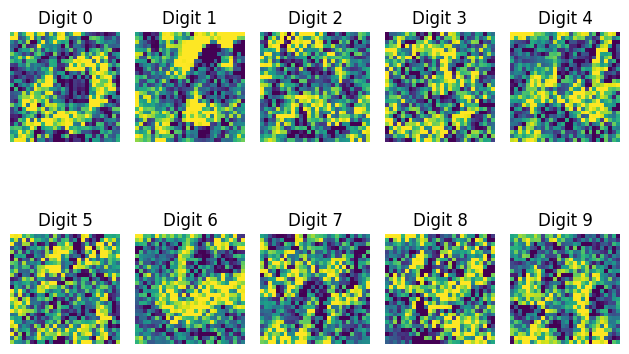

Dreaming with different penalization parameter lambda
Step 0, Loss: -4.7499
Step 100, Loss: -0.0030
Step 200, Loss: -0.0021
Step 300, Loss: -0.0017
Step 400, Loss: -0.0015
Step 500, Loss: -0.0013
Step 600, Loss: -0.0012
Step 700, Loss: -0.0012
Step 800, Loss: -0.0011
Step 900, Loss: -0.0010


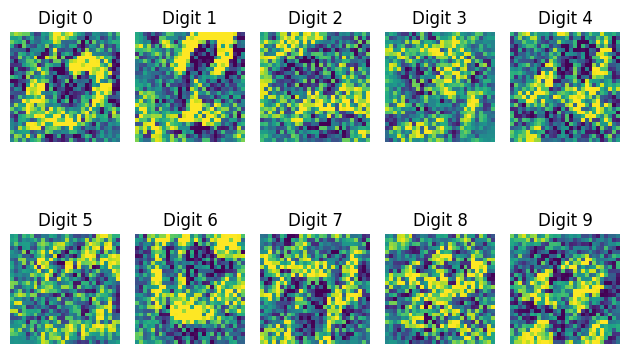

Step 0, Loss: -4.3303
Step 100, Loss: -0.0108
Step 200, Loss: -0.0091
Step 300, Loss: -0.0080
Step 400, Loss: -0.0071
Step 500, Loss: -0.0064
Step 600, Loss: -0.0058
Step 700, Loss: -0.0053
Step 800, Loss: -0.0048
Step 900, Loss: -0.0045


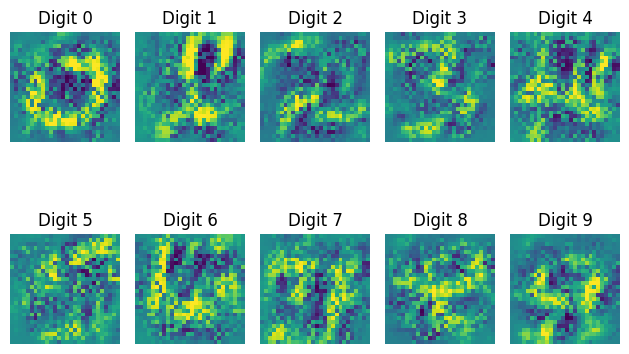

Step 0, Loss: -5.4708
Step 100, Loss: -0.0607
Step 200, Loss: -0.0385
Step 300, Loss: -0.0273
Step 400, Loss: -0.0212
Step 500, Loss: -0.0177
Step 600, Loss: -0.0157
Step 700, Loss: -0.0145
Step 800, Loss: -0.0137
Step 900, Loss: -0.0132


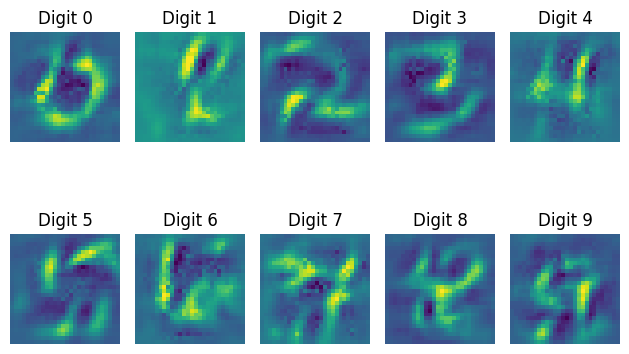

Step 0, Loss: -5.7152
Step 100, Loss: -0.1267
Step 200, Loss: -0.0765
Step 300, Loss: -0.0707
Step 400, Loss: -0.0696
Step 500, Loss: -0.0692
Step 600, Loss: -0.0691
Step 700, Loss: -0.0691
Step 800, Loss: -0.0691
Step 900, Loss: -0.0691


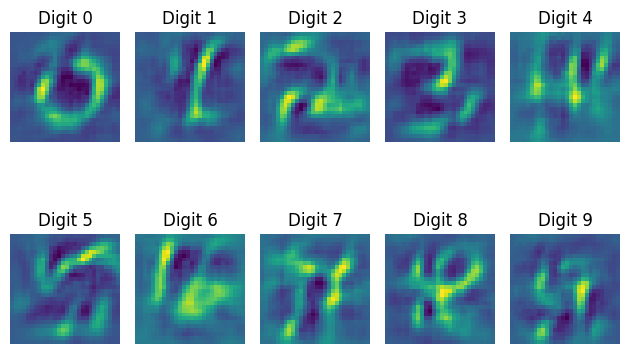

Step 0, Loss: -14.6098
Step 100, Loss: -0.3401
Step 200, Loss: -0.3328
Step 300, Loss: -0.3328
Step 400, Loss: -0.3329
Step 500, Loss: -0.3329
Step 600, Loss: -0.3329
Step 700, Loss: -0.3329
Step 800, Loss: -0.3330
Step 900, Loss: -0.3330


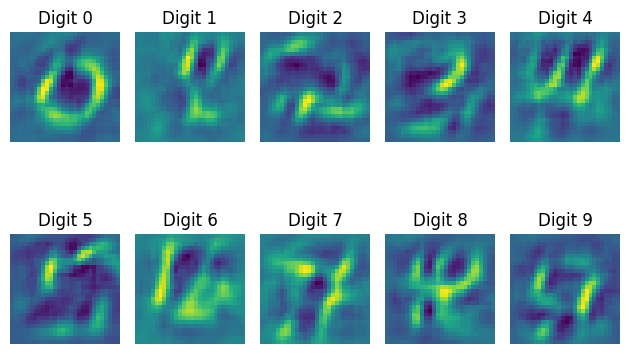

In [5]:
print("Dreaming without penalization (LeNet5)")
dreamingLeNet5()

print("Dreaming with different penalization parameter lambda")
lambda_l2 = 0.001

for i in range(5):
    dreamingLeNet5(lambda_l2=lambda_l2 * (10 ** i))   #Penalization 

# DISCUSSION

The outputs are way better recogisable from this LeNet5 model that previous Multi layered perceptron. With higher penalisation numbers almost resemble bad handwriting.

Architecture benefits of LeNet5:
- Each layer is responisble for bigger features in image
- Each filter is used on whole image (for example filter responible for detecting edges)
- Local receptive field of each neuron (not whole image)

# TASK 2 - LEARNING NOISE

Here im just experimenting with noise

In [6]:
# def add_noise(img, mean=0.0, std=0.5, noise_coef = 2):
#     if img.ndim == 3:
#         img = img.squeeze(0)

#     noise = torch.randn_like(img) * std
#     noise = noise * (0.5 - img) * noise_coef
#     # plt.imshow(noise)
    
#     noisy_img = torch.clamp(img + noise, 0.0, 1.0)
#     return noisy_img


# train_image, train_target = trainset[5]
# plt.subplot(1, 2, 1)
# plt.title("Original")
# plt.imshow(train_image.squeeze())

# noisy_image = add_noise(train_image, noise_coef=1)
# plt.subplot(1,2,2)
# plt.title("Added noise")
# plt.imshow(noisy_image.squeeze())
# plt.show()              

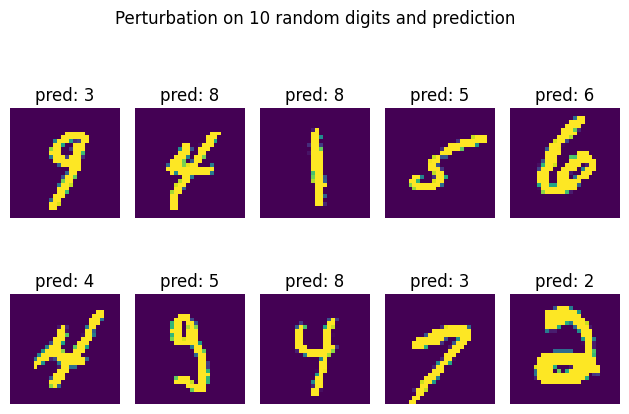

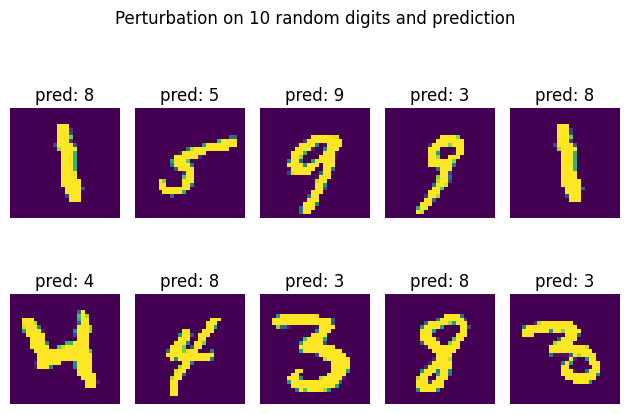

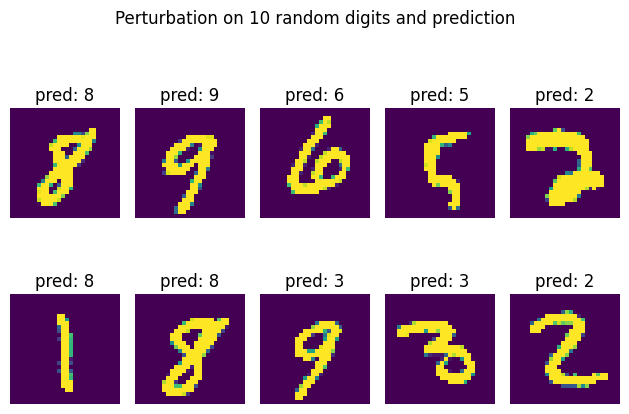

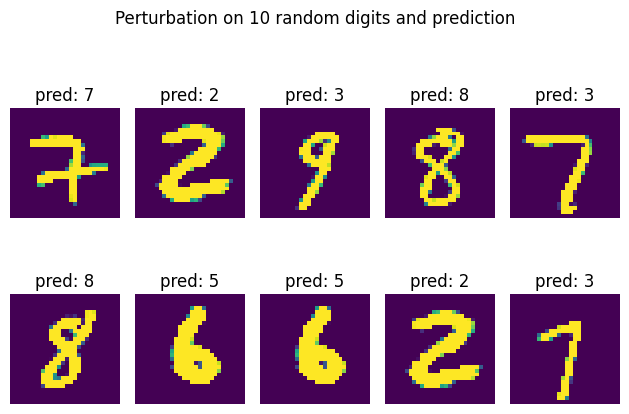

In [ ]:
import random

def learning_noise(images, targets, lambda_l2=0):
    # images, targets = get_batch_n_samples(trainset, n_per_class=9)  # (90,1,2,28), (90,)
    images = images.to(device)
    targets = targets.to(device)
    wrong_targets = (targets + 1) % 10

    delta = torch.zeros((1,28,28), requires_grad=True, device=device)
    

    model.eval()
    optimizer = torch.optim.Adam([delta], lr=0.05)


    for step in range(1000):
        optimizer.zero_grad()

        delta_x10 = delta.expand(images.shape)
        perturbed_img = (images + delta_x10).clamp(0,1)
        outputs = model(perturbed_img)

        loss1 = torch.nn.functional.cross_entropy(outputs, wrong_targets)
        loss2 = lambda_l2 * delta.pow(2).mean()
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()

        delta.data.clamp_(-0.3, 0.3)

        # if step % 100 == 0:
        #     print(f"Step {step}, Loss: {-loss.item():.4f}")

    # Visualization
    with torch.no_grad():
        perturbed_images = (images + delta.expand(images.shape)).clamp(0, 1)
        for i in range(10):
            idx = random.randint(0,80)             # some random index
            plt.subplot(2, 5, i+1)
            plt.imshow(perturbed_images[idx].squeeze(0).cpu())
            plt.title(f"pred: {torch.argmax(model(perturbed_images[idx:idx+1])).item()}")
            plt.axis('off')

        plt.suptitle("10 randomly chosen digits + perturbation and prediction")
        plt.tight_layout()
        plt.show()

    return delta


learning_noise(train_images, train_targets)

lambda_l2 = 0.01
for i in range(1,4):
    delta = learning_noise(train_images, train_targets, lambda_l2=lambda_l2 * (10 ** i))


# Testing accuracy after perturbation. Smaller means better trained $\delta$

Accuracy (with perturbation): 0.6677


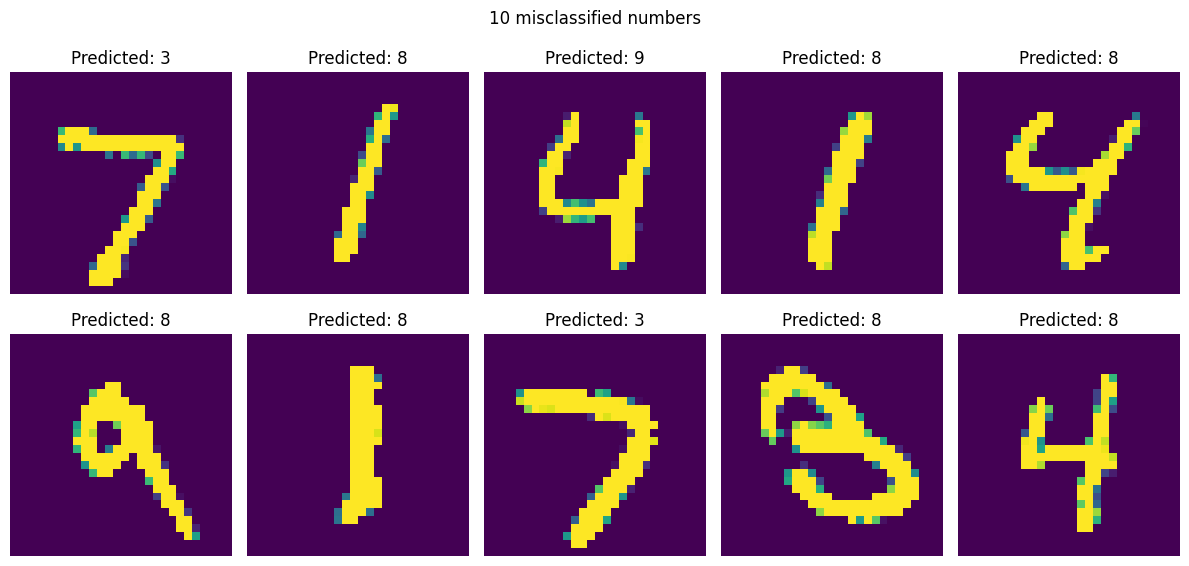

In [ ]:
good = 0
wrong = 0
model.eval()
delta = delta.cpu()
cool_examples = []

with torch.no_grad():  
    for images, labels in testloader:
        perturbed_images = (images + delta.expand_as(images)).clamp(0, 1)
        outputs = model(perturbed_images.to(device))
        preds = torch.argmax(outputs, dim=1).cpu()

        for i in range(len(labels)):
            if preds[i].item() == labels[i].item():
                good += 1
            else:
                if len(cool_examples) < 10:
                    cool_examples.append((images[i], perturbed_images[i], preds[i].item(), labels[i].item()))
                wrong += 1

                if len(cool_examples) >= 10:
                    break 

accuracy = good / (good + wrong)
print(f"Accuracy (with perturbation): {accuracy:.4f}")


plt.figure(figsize=(12, 6))
for idx, (orig, pert, pred, true) in enumerate(cool_examples):
    plt.subplot(2, 5, idx+1)
    plt.imshow(pert.squeeze())
    plt.title(f"Predicted: {pred}")
    plt.axis("off")

plt.suptitle("10 misclassified numbers")
plt.tight_layout()
plt.show()


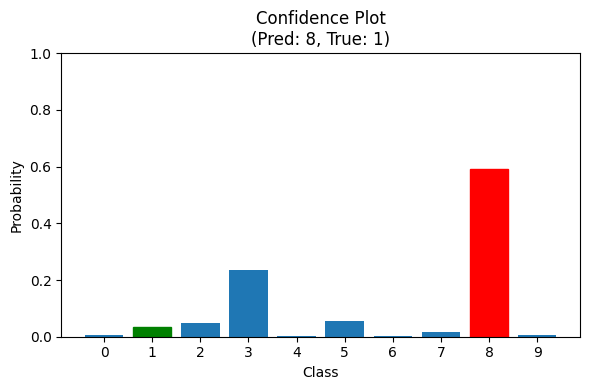

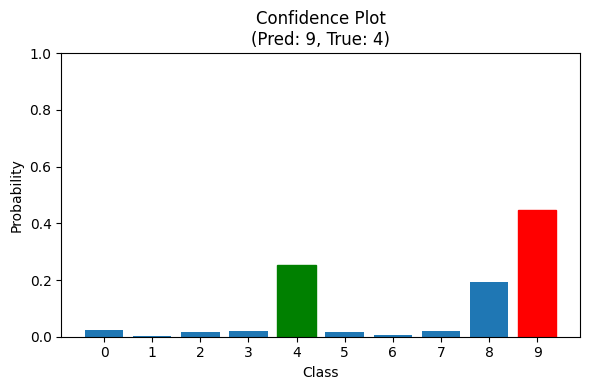

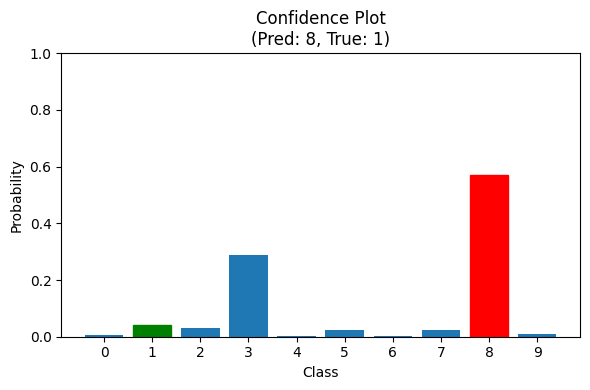

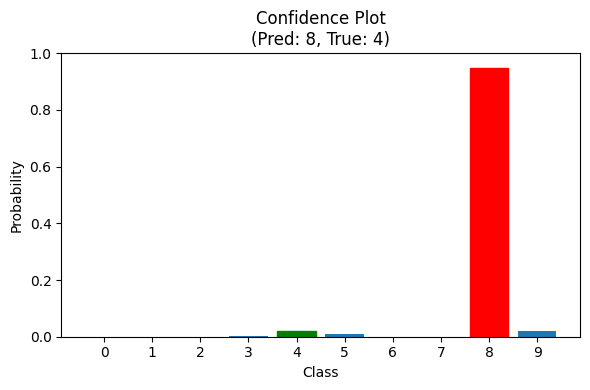

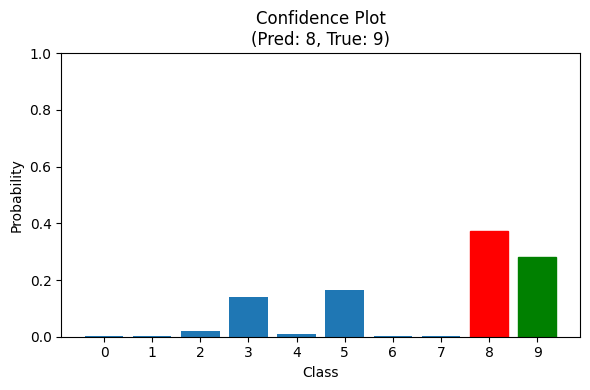

In [14]:
def plot_confidence(output_logits, true_label=None, title="Confidence Plot"):
    import matplotlib.pyplot as plt
    import numpy as np

    probs = torch.softmax(output_logits, dim=0).cpu().numpy()
    pred_label = np.argmax(probs)

    plt.figure(figsize=(6, 4))
    bars = plt.bar(range(10), probs)

    bars[pred_label].set_color('red')
    if true_label is not None:
        bars[true_label].set_color('green')

    plt.xticks(range(10))
    plt.ylim(0, 1)
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.title(title + f"\n(Pred: {pred_label}, True: {true_label})")
    plt.tight_layout()
    plt.show()


model.eval()
with torch.no_grad():
    for idx in [1,2,3,4,5]:
        orig_img, pert_img, pred_label, true_label = cool_examples[idx]
        output_logits = model(pert_img.unsqueeze(0).to(device)).squeeze()
        plot_confidence(output_logits, true_label)

# DISCUSSION

After training perturbation $\delta$ on 9*10 images we got around 65% accuracy of the LeNet5. Hyperparameters $\lambda=1$ and different `delta.data.clamp_(-0.3, 0.3)` values doesn't significantly increase attack on the model. Lambda does not strongly affect the images, but `data.clamp` keeps perturbed images more recognisable by humans while keeping features that affect accuracy of the model. Fine tuning of these parameters is highly recommended.

Some predictions are less confident than others. For example LeNet5 see 3,5,8 and 9 with perturbations as very similar numbers. Model prefers 8 maybe because of "curvy" shapes and two main oval structures that resemble other numbers. But with 4 model is overconfident.
  

